In [1]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

objc[78227]: Class CaptureDelegate is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x104b7c860) and /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x159902480). One of the two will be used. Which one is undefined.
objc[78227]: Class CVWindow is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x103710a68) and /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x1599024d0). One of the two will be used. Which one is undefined.
objc[78227]: Class CVView is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x103710a90) and /Users/fuixlabsdev1/Programming/PP/graduation-th

### 1. Set up important functions

In [2]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

### 2. Capture landmarks and Export to CSV

#### Generate Data Frame

According to my research *the correct form* for a squat is analyzed through the position of:
- Back
- Hip
- Legs

Therefore, there will be *9 keypoints* which will be extract from mediapipe in order to train or detect a correct form of a squat:
- "NOSE",
- "LEFT_SHOULDER",
- "RIGHT_SHOULDER",
- "LEFT_HIP",
- "RIGHT_HIP",
- "LEFT_KNEE",
- "RIGHT_KNEE",
- "LEFT_ANKLE",
- "RIGHT_ANKLE"

The data frame will be saved in a .csv file.

A data frame will contains a "Label" columns which represent the label of a data point.

There are another 9 x 4 columns represent 9 features of a human pose that are important for a squat.
In that each landmark's info will be flatten

According to the [Mediapipe documentation](https://google.github.io/mediapipe/solutions/pose#python-solution-api),
Each landmark consists of the following:
- x and y: Landmark coordinates normalized to [0.0, 1.0] by the image width and height respectively.
- z: Represents the landmark depth with the depth at the midpoint of hips being the origin, and the smaller the value the closer the landmark is to the camera. The magnitude of z uses roughly the same scale as x.
- visibility: A value in [0.0, 1.0] indicating the likelihood of the landmark being visible (present and not occluded) in the image.

In [4]:
# Determine important landmarks for squat
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

# Generate all columns of the data frame

landmarks = ["label"] # Label column

for lm in IMPORTANT_LMS:
    landmarks += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [29]:
landmarks[1:]

['nose_x',
 'nose_y',
 'nose_z',
 'nose_v',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_z',
 'left_shoulder_v',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_z',
 'right_shoulder_v',
 'left_hip_x',
 'left_hip_y',
 'left_hip_z',
 'left_hip_v',
 'right_hip_x',
 'right_hip_y',
 'right_hip_z',
 'right_hip_v',
 'left_knee_x',
 'left_knee_y',
 'left_knee_z',
 'left_knee_v',
 'right_knee_x',
 'right_knee_y',
 'right_knee_z',
 'right_knee_v',
 'left_ankle_x',
 'left_ankle_y',
 'left_ankle_z',
 'left_ankle_v',
 'right_ankle_x',
 'right_ankle_y',
 'right_ankle_z',
 'right_ankle_v']

In [48]:
DATASET_PATH = "./data_frame.csv"

def init_csv(dataset_path: str):
    '''
    Create a blank csv file with just columns
    '''

    # Write all the columns to a file
    with open(dataset_path, mode="w", newline="") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(landmarks)

In [ ]:
# landmarks = results.pose_landmarks.landmark
# for res in landmarks:
#     for lm in IMPORTANT_LMS:
#         keypoints = landmarks[mp_pose.PoseLandmark[lm].value]
#         print(lm, keypoints)

In [6]:

def export_landmark_to_csv(dataset_path: str, results, action: str) -> None:
    '''
    Export Labeled Data from detected landmark to csv
    '''
    landmarks = results.pose_landmarks.landmark
    keypoints = []

    try:
        # Extract coordinate of important landmarks
        for lm in IMPORTANT_LMS:
            keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
            keypoints.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
        
        keypoints = list(np.array(keypoints).flatten())

        # Insert action as the label (first column)
        keypoints.insert(0, action)

        # Append new row to .csv file
        with open(dataset_path, mode="a", newline="") as f:
            csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
        

    except Exception as e:
        print(e)
        pass


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {duplicate.sum(axis=1)}")

    return data
    

Extract and labeled data from the video dataset

In [72]:
cap = cv2.VideoCapture("../data/squat_right_4.mp4")
up_save_count = 0
down_save_count = 0

# path = "./squat4.csv"

init_csv(DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        # Reduce size of a frame
        image = rescale_frame(image, 80)

        if not ret:
            break

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"UP saved: {up_save_count}", (50, 150), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, f"DOWN saved: {down_save_count}", (50, 200), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow("CV2", image)
        # Press to extract and save to .csv
        pressed_key = cv2.waitKey(1)

        # Pressed U to label frame as UP position
        if pressed_key == 117:
            export_landmark_to_csv(DATASET_PATH, results, "up")
            up_save_count += 1

        # Pressed D to label frame as DOWN position
        if pressed_key == 100:
            export_landmark_to_csv(DATASET_PATH, results, "down")
            down_save_count += 1
        
        
        # Press Q to close cv2 window
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)
        

In [ ]:
def concat_csv_files_with_same_headers(file_paths: list, saved_path: str):
    '''
    Concat different csv files
    '''
    all_df = []
    for path in file_paths:
        df = pd.read_csv(path, index_col=None, header=0)
        all_df.append(df)
    
    results = pd.concat(all_df, axis=0, ignore_index=True)
    results.to_csv(saved_path, sep=',', encoding='utf-8', index=False)

# concat_csv_files_with_same_headers(["./squat1.csv", "./squat2.csv", "./squat3.csv", "./squat4.csv"], DATASET_PATH)

### 4. Train custom model using Scikit Learn

#### 4.1 Read and describe data

In [106]:
from sklearn.model_selection import train_test_split

In [9]:
# Brief describe of the dataset
df = describe_dataset("./dataset.csv")
df.head(5)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 374 
Number of columns: 37

Labels: 
up      188
down    186
Name: label, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: float64)


,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_knee_z,right_knee_v,left_ankle_x,left_ankle_y,left_ankle_z,left_ankle_v,right_ankle_x,right_ankle_y,right_ankle_z,right_ankle_v
0,down,0.600248,0.433268,-0.006637,0.999949,0.650759,0.517787,0.041632,0.994121,0.571711,...,-0.133012,0.976462,0.659328,0.836607,-0.294549,0.994219,0.575143,0.814380,-0.157936,0.966270
1,down,0.600160,0.449894,-0.008615,0.999966,0.651127,0.535333,0.036240,0.994432,0.571456,...,-0.115595,0.974204,0.659568,0.831231,-0.279601,0.993431,0.576560,0.812989,-0.135235,0.959162
2,down,0.599425,0.466234,-0.047636,0.999957,0.651464,0.550511,-0.021722,0.994265,0.571824,...,-0.084128,0.949108,0.659044,0.828410,-0.202085,0.987354,0.575949,0.813362,-0.053549,0.928765
3,down,0.597382,0.485779,-0.057994,0.999926,0.651386,0.571049,-0.023268,0.994848,0.572379,...,-0.069531,0.921725,0.658455,0.832319,-0.168358,0.982599,0.576511,0.813286,-0.058735,0.904242
4,down,0.594474,0.438586,-0.041261,0.999931,0.650657,0.518908,-0.003251,0.993209,0.571241,...,-0.119639,0.969358,0.658565,0.836644,-0.274596,0.994046,0.576144,0.815093,-0.117950,0.965770


In [ ]:
t = df[['nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']].apply(lambda x: pd.Series.round(x, 2))
t.to_csv("round.csv")

<AxesSubplot:xlabel='count', ylabel='label'>

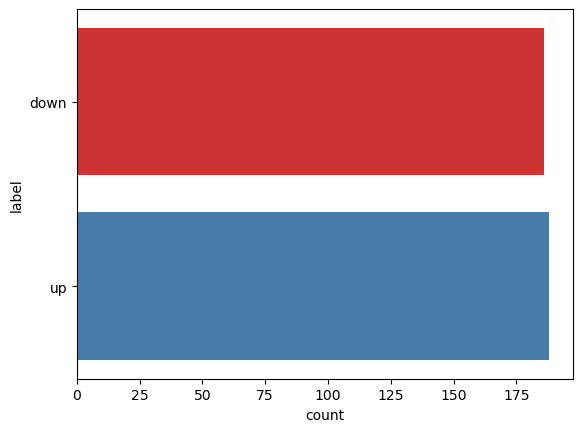

In [12]:
sns.countplot(y='label', data=df, palette="Set1")

In [105]:
# Extract features and class

X = df.drop("label", axis=1) # features
y = df["label"]


In [108]:
# Split train set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [110]:
y_test.head(10)

286    down
71       up
66       up
118      up
29     down
67       up
149    down
64       up
91       up
133      up
Name: label, dtype: object

#### 4.2 Train Machine learning model

In [129]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

In [138]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC()),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", SGDClassifier()),
         ("Ridge", RidgeClassifier()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average="macro")
    a_score = accuracy_score(y_test, model_results)
    f1_score_result = f1_score(y_test, model_results, average=None, labels=["down", "up"])
    final_results.append(( name, p_score, a_score, f1_score_result ))


final_results.sort(key=lambda k: k[3][0] + k[3][1], reverse=True)

In [139]:
# Display model results 

pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score" , "F1 score"])

,Model,Precision Score,Accuracy score,F1 score
0,LR,1.000000,1.000000,"[1.0, 1.0]"
1,SVC,1.000000,1.000000,"[1.0, 1.0]"
2,DTC,1.000000,1.000000,"[1.0, 1.0]"
3,Ridge,1.000000,1.000000,"[1.0, 1.0]"
4,RF,1.000000,1.000000,"[1.0, 1.0]"
5,KNN,0.991667,0.991150,"[0.9915966386554621, 0.9906542056074767]"
6,SGDC,0.983607,0.982301,"[0.9833333333333333, 0.9811320754716981]"


#### 4.3. Dumped model using pickle

According to the evaluations, there are multiple good models at the moment, therefore, I will pick the Random Forrest model to use.

In [152]:
# Dump the best model to a pickle file
import pickle

with open("./squat_model.pkl", "wb") as f:
    pickle.dump(models["RF"], f)